## import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch 
from torch import distributions
from torch import nn
from torch.utils import data

## MCMC

In [2]:
#mcmc for 1-dimensional case
def MCMC_sampler(E,xstart=0.,n_sample=10000,std=0.1,n_stride=10):
  samples=[]
  for j in range(n_stride):
    x_cur=xstart
    e_cur=E(x_cur)
    for i in range(int(n_sample/n_stride)):
      dx=std*np.random.normal()
      x_prop=x_cur+dx
      e_prop=E(x_prop)
      e_diff=e_prop-e_cur
      log_r=-np.log(np.random.uniform())
      acc=float(log_r>e_diff)
      rej=1.-acc
      x_cur=x_prop*acc+x_cur*rej
      e_cur=e_prop*acc+e_cur*rej
      samples.append(x_cur)  
  return samples

## data

#### function

In [3]:
#energy of x-part of doublewell
def E( x, a=1, b=-6, c=0):
  return a*x**4+b*x**2+c*x

In [4]:
#sample from doublewell model by mcmc
def brute_sample(E,n_sample=10000):
  half_num=int(n_sample/2)
  xl=MCMC_sampler(E,-2,half_num)
  xr=MCMC_sampler(E,2,half_num)
  x1=np.append(xl,xr)
  x2=np.random.normal(size=n_sample)
#  print(len(xl),len(x2))
  x=np.vstack((x1,x2)).T
  return x

In [5]:
#plot exact energy and generated energy
def plot_energy(x):
  counts, bins = np.histogram(x, bins = 200 )
  anchors = (bins[1:] + bins[:-1]) / 2
  probs = counts / np.sum(counts)

  anchors = anchors[np.where(probs > 0.0001)]
  probs = probs[np.where(probs > 0.0001)]

  f = -np.log(probs)
  fn = f - np.min(f)
  x_mesh = np.linspace(-2.5,2.5,1000)
  E_mesh = E(x_mesh)
  E_mesh=E_mesh-E_mesh.min()
  plt.scatter(anchors, fn) 

  plt.xlabel("$x_1$")
  plt.ylabel(r"$(f - f_0) / k_B T$")

  plt.plot(x_mesh,E_mesh)

  plt.show()
  return 0

#### data

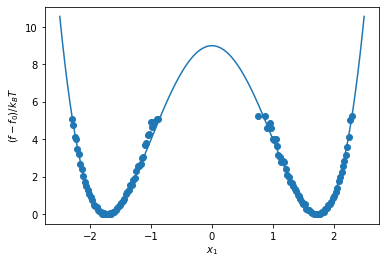

Text(0.5, 1.0, '$X = g(z)$')

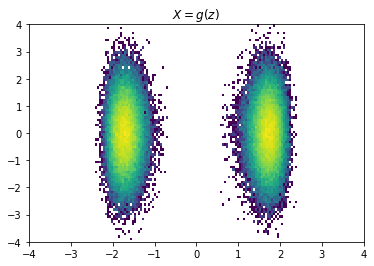

In [6]:
#generate samples by mcmc as exact sample
x_brute=brute_sample(E,100000)
plot_energy(x_brute[:,0])

ax=plt.gca()
ax.hist2d(x_brute[:,0],x_brute[:,1],bins=100,norm=matplotlib.colors.LogNorm())
#plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$X = g(z)$')

## Model

In [7]:
#define normalizing flow model
class RealNVP_stochastic(nn.Module):
    def __init__(self,stochastic=False,step_size=0.2,nsteps=10,n_hidden=256,prior=None,n_block=5,masks=None,nets=None,nett=None,target=True):
        super(RealNVP_stochastic,self).__init__()
        self.stochastic=stochastic # true for snf , false for nf

        #only for snf
        self.step_size=step_size 
        self.nsteps=nsteps 

        #target model: default is doublewell
        self.target=target

        #construction of each layer of flow
        if nets==None:
          nets = lambda: nn.Sequential(nn.Linear(2, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, 2), nn.Tanh())
        if nett==None:
          nett = lambda: nn.Sequential(nn.Linear(2, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, 2))

        #prior model: default is gaussian
        if prior==None:
          self.prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

        #hyperpara for nn
        self.n_hidden=n_hidden
        self.n_block=n_block
        if masks==None:
          self.masks = nn.Parameter(torch.from_numpy(np.array([[0, 1], [1, 0]] * self.n_block).astype(np.float32)), requires_grad=False)

        self.nett = torch.nn.ModuleList([nett() for _ in range(len(self.masks))]) # translation term in flow
        self.nets = torch.nn.ModuleList([nets() for _ in range(len(self.masks))]) # scaling  term in flow

    #target energy
    def target_energy(self,x):
        target=self.target
        if target==None:
            return self.prior_energy(x)
        elif target==True:
            return self.proposal_energy(x)
    
    #target energy: default is doublewell
    def proposal_energy(self, x, a=1, b=-6, c=0, d=1):
        if (len(x.shape) > 1):
            return a*x[:,0]**4 + b*x[:,0]**2 + c*x[:,0] + d*x[:,1]**2/2
        else:
            return a*x[0]**4 + b*x[0]**2 + c*x[0] + d*x[1]**2/2
    
    #prior energy:gaussian energy
    def prior_energy(self, z):
        return 0.5*torch.linalg.norm(z,dim=1)**2

    #stochastic step in forward flow
    def MCMC_forward(self, x ):
        stepsize=self.step_size
        nsteps=self.nsteps
        E0 = self.target_energy(x).reshape((x.shape[0],1))
        Et = E0
        for i in range(nsteps):
            # proposal step
            dx = stepsize * torch.zeros_like(x).normal_()
            xprop = x + dx
            Eprop = self.target_energy(xprop).reshape((x.shape[0],1))
            # acceptance step
            acc = (torch.rand(x.shape[0],1) < torch.exp(-(Eprop - Et))).float() 
            x = (1-acc) * x + acc * xprop
            Et = (1-acc) * Et + acc * Eprop

        dW = (Et - E0).reshape(x.shape[0],)
        return x, dW

    #stochastic step in backward flow
    def MCMC_backward(self, z):
        stepsize=self.step_size
        nsteps=self.nsteps
        E0 = self.prior_energy(z).reshape((z.shape[0],1))
        Et = E0
        for i in range(nsteps):
            # proposal step
            dz = stepsize * torch.zeros_like(z).normal_()
            zprop = z + dz
            Eprop = self.prior_energy(zprop).reshape((z.shape[0],1))
            # acceptance step
            acc = (torch.rand(z.shape[0],1) < torch.exp(-(Eprop - Et))).float()
            z = (1-acc) * z + acc * zprop
            Et = (1-acc) * Et + acc * Eprop

        dW = (Et - E0).reshape(z.shape[0],)
        return z, dW

    #forward flow (z->x), return x and jacobian
    def forward_flow(self,z):
        stochastic=self.stochastic
        log_R_zx, x = z.new_zeros(z.shape[0]), z

        for i in range(len(self.masks)):
            x1= x*self.masks[i]

            s=self.nets[i](x1)*(1-self.masks[i])
            t=self.nett[i](x1)*(1-self.masks[i])

            x=x1+(1-self.masks[i])* (x*torch.exp(s)+t)
            log_R_zx+=torch.sum(s,-1)
            if stochastic==True:
                x,dw=self.MCMC_forward(x)
                log_R_zx+=dw
        return x, log_R_zx

    #backward flow (x->z), return z and jacobian
    def backward_flow(self,x):
        stochastic=self.stochastic
        log_R_xz, z = x.new_zeros(x.shape[0]), x

        for i in reversed(range(len(self.masks))):
            if stochastic==True:
                z, dw=self.MCMC_backward(z)
                log_R_xz+=dw

            z1= z*self.masks[i]

            s=self.nets[i](z1)*(1-self.masks[i])
            t=self.nett[i](z1)*(1-self.masks[i])

            z=z1+(1-self.masks[i])*(z-t)*torch.exp(-s)
            log_R_xz-=torch.sum(s,-1)

        return z, log_R_xz

    #sample from prior and transform to x,(return z,x and jacobian)
    def sample(self, batchSize):
        z = self.prior.sample((batchSize,))
        x, log_R_zx = self.forward_flow(z)
        return z.detach().numpy() , x.detach().numpy(), log_R_zx.detach().numpy()
    

    #loss for maximum likelihood training(backward)
    def loss_ml(self, batch_x):
        z, log_R_xz = self.backward_flow(batch_x)
        energy=0.5*torch.linalg.norm(z,dim=1)**2
        return torch.mean(energy-log_R_xz)
    
    #loss for kl training(forward)
    def loss_kl(self, batch_z):
        x, log_R_zx = self.forward_flow(batch_z)
        energy=self.target_energy(x)
        e_high=1e3
        for i in range(len(energy)):
            if abs(energy[i]) == float('inf'):
                  print("energy overflow detected")
            elif energy[i] > e_high:
                  energy[i] = e_high + torch.log(energy[i] - e_high + 1.0)
        return torch.mean(energy - log_R_zx)  
    
    def loss_mix(self, batch_x, batch_z=None, w_kl=0.5, w_ml=0.5):
        if batch_z==None:
            batch_z = self.prior.sample((batch_x.shape[0],))
        return w_kl*self.loss_kl(batch_z)+w_ml*self.loss_ml(batch_x)        

## BG

#### ML

In [8]:
model_BG=RealNVP_stochastic(stochastic=False)

In [9]:
#parameter
iter1=400
iter2=400
lr1=1e-3
lr2=1e-3
batch_size1=2000
batch_size2=2000

In [10]:
#set training data
training_data=x_brute
np.random.shuffle(training_data)
training_data.shape

(100000, 2)

In [11]:
#prepare for training
optimizer = torch.optim.Adam(model_BG.parameters(), lr=lr1) 

training_data = training_data.astype('float32')

trainloader = data.DataLoader(dataset=training_data, batch_size=batch_size1)

losses = [] 


In [12]:
#ML training
t = 0 
while t < iter1:
    for batch in trainloader:  
        
        #ML loss function
        loss = model_BG.loss_ml(batch) 
        losses.append(loss.item()) # save values for plotting later 
    
        # Training
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        t = t + 1
        if t % 25 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

iter 25: loss = 0.922
iter 50: loss = 0.438
iter 75: loss = 0.273
iter 100: loss = 0.205
iter 125: loss = 0.200
iter 150: loss = 0.220
iter 175: loss = 0.175
iter 200: loss = 0.173
iter 225: loss = 0.168
iter 250: loss = 0.201
iter 275: loss = 0.167
iter 300: loss = 0.190
iter 325: loss = 0.163
iter 350: loss = 0.156
iter 375: loss = 0.160
iter 400: loss = 0.145


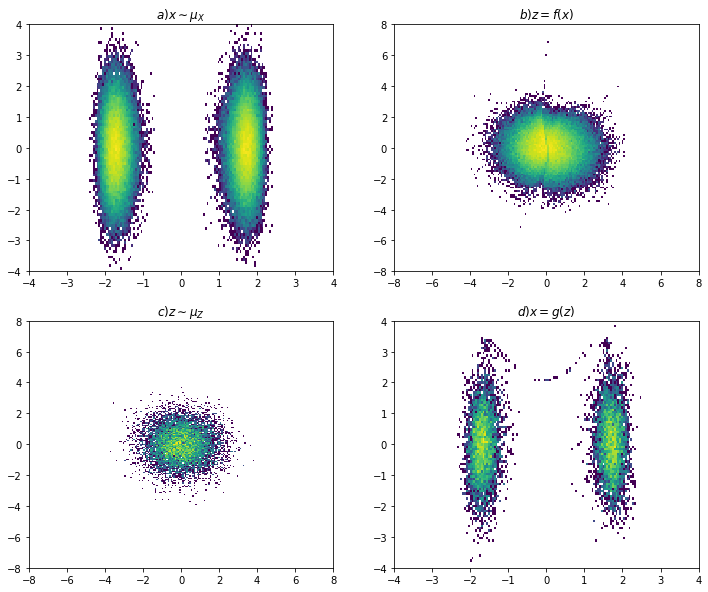

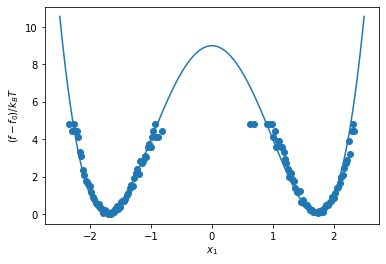

0

In [13]:
# Visualize
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(221)
ax=plt.gca()
ax.hist2d(x_brute[:,0],x_brute[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$a) x \sim \mu_X$')

# sample from x and transform to z 
zb=model_BG.backward_flow(torch.from_numpy(training_data))[0].detach().numpy()
plt.subplot(222)
ax=plt.gca()
ax.hist2d(zb[:,0],zb[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$b) z = f(x)$')

# sampling from gaussian and transform to x
z, x, _ = model_BG.sample(10000)

#plot gaussian
plt.subplot(223)
ax=plt.gca()
ax.hist2d(z[:,0],z[:,1],bins=100,norm=matplotlib.colors.LogNorm())
#plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$c) z \sim \mu_Z$')

# plot x transformed from gaussian
plt.subplot(224)
ax=plt.gca()
ax.hist2d(x[:,0],x[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$d) x = g(z)$')

plt.show()

#plot energy
plot_energy(x[:,0]) #plot energy

#### MIX

In [14]:
training_set_2 = training_data
trainloader_2 = data.DataLoader(dataset=training_set_2, batch_size=batch_size2)
optimizer2 = torch.optim.Adam(model_BG.parameters(), lr=lr2) 
while t < iter1+iter2:
    for batch_x in trainloader_2:  
        # KL loss function
        loss = model_BG.loss_mix(batch_x)
        losses.append(loss.item())
    
        # Training on KL loss
        optimizer2.zero_grad()
        loss.backward(retain_graph=True)
        optimizer2.step()
        
        t = t + 1
        if t % 25 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

iter 425: loss = -3.028
iter 450: loss = -3.340
iter 475: loss = -3.370
iter 500: loss = -3.363
iter 525: loss = -3.394
iter 550: loss = -3.413
iter 575: loss = -3.426
iter 600: loss = -3.465
iter 625: loss = -3.441
iter 650: loss = -3.434
iter 675: loss = -3.401
iter 700: loss = -3.464
iter 725: loss = -3.440
iter 750: loss = -3.441
iter 775: loss = -3.451
iter 800: loss = -3.440


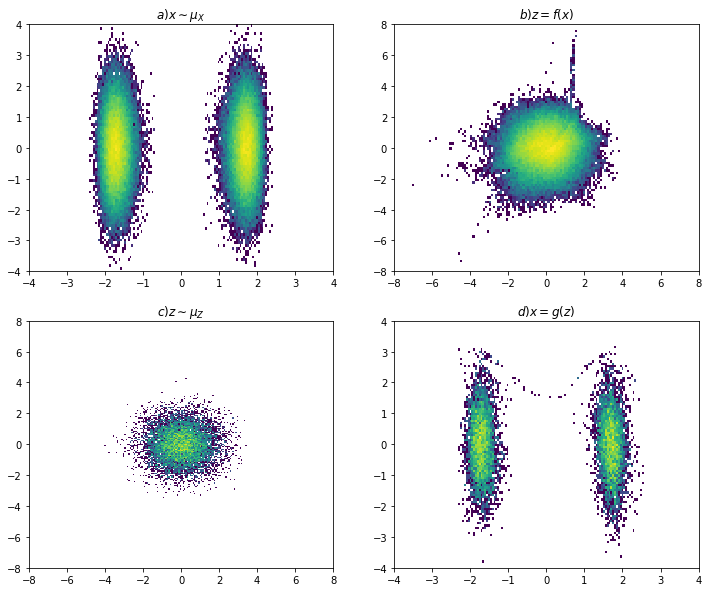

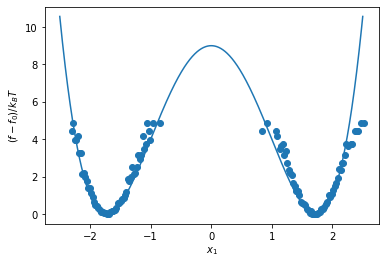

0

In [15]:
# Visualize
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(221)
ax=plt.gca()
ax.hist2d(x_brute[:,0],x_brute[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$a) x \sim \mu_X$')

# sample from x and transform to z 
zb=model_BG.backward_flow(torch.from_numpy(training_data))[0].detach().numpy()
plt.subplot(222)
ax=plt.gca()
ax.hist2d(zb[:,0],zb[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$b) z = f(x)$')

#
z, x, _ = model_BG.sample(10000)
plt.subplot(223)
ax=plt.gca()
ax.hist2d(z[:,0],z[:,1],bins=100,norm=matplotlib.colors.LogNorm())
#plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$c) z \sim \mu_Z$')

#
plt.subplot(224)
ax=plt.gca()
ax.hist2d(x[:,0],x[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$d) x = g(z)$')

plt.show()

plot_energy(x[:,0]) #plot energy

## SNF

In [16]:
model_SNF=RealNVP_stochastic(stochastic=True)
#the following steps are same as BG case above 

In [17]:
iter1=400
iter2=400
lr1=1e-3
lr2=1e-3
batch_size1=2000
batch_size2=2000

#### ML

In [18]:
training_data=x_brute
np.random.shuffle(training_data)
training_data.shape

(100000, 2)

In [19]:
optimizer = torch.optim.Adam(model_SNF.parameters(), lr=lr1) 

training_data = training_data.astype('float32')

trainloader = data.DataLoader(dataset=training_data, batch_size=batch_size1)

losses = []


In [20]:
t = 0 
while t < iter1:
    for batch in trainloader:  

        # ML loss function
        loss = model_SNF.loss_ml(batch) 
        losses.append(loss.item())
    
        # Training
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        t = t + 1
        if t % 25 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

iter 25: loss = 2.848
iter 50: loss = 2.167
iter 75: loss = 1.904
iter 100: loss = 1.807
iter 125: loss = 1.833
iter 150: loss = 1.821
iter 175: loss = 1.827
iter 200: loss = 1.805
iter 225: loss = 1.843
iter 250: loss = 1.817
iter 275: loss = 1.834
iter 300: loss = 1.812
iter 325: loss = 1.847
iter 350: loss = 1.839
iter 375: loss = 1.826
iter 400: loss = 1.798


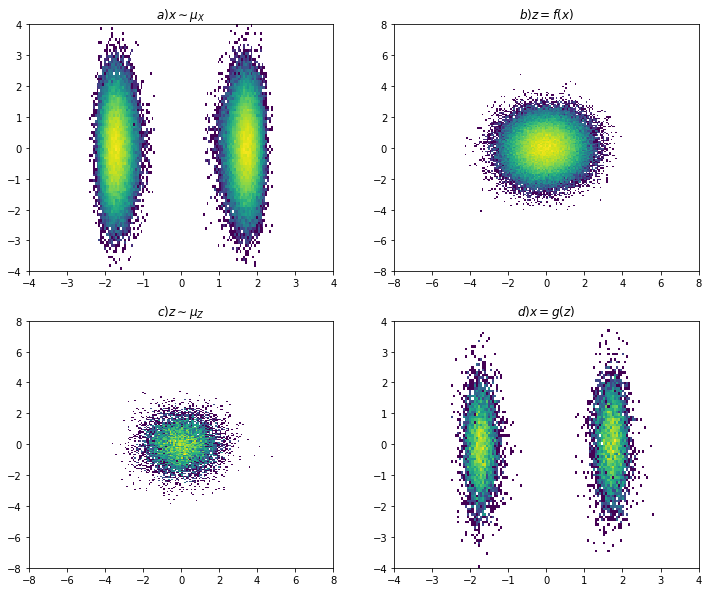

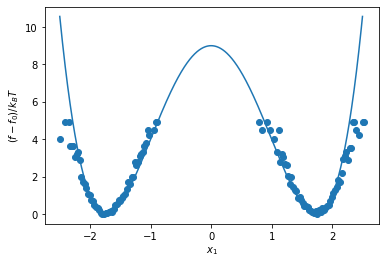

0

In [21]:
# Visualize 
fig, axes = plt.subplots(2, 2, figsize = (12,10))

#
plt.subplot(221)
ax=plt.gca()
ax.hist2d(x_brute[:,0],x_brute[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$a) x \sim \mu_X$')

#
zb=model_SNF.backward_flow(torch.from_numpy(training_data))[0].detach().numpy()
plt.subplot(222)
ax=plt.gca()
ax.hist2d(zb[:,0],zb[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$b) z = f(x)$')

#
z, x, _ = model_SNF.sample(10000)
plt.subplot(223)
ax=plt.gca()
ax.hist2d(z[:,0],z[:,1],bins=100,norm=matplotlib.colors.LogNorm())
#plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$c) z \sim \mu_Z$')

#
plt.subplot(224)
ax=plt.gca()
ax.hist2d(x[:,0],x[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$d) x = g(z)$')

plt.show()

plot_energy(x[:,0]) #plot energy

#### MIX

In [22]:
training_set_2 = training_data
trainloader_2 = data.DataLoader(dataset=training_set_2, batch_size=batch_size2)
optimizer2 = torch.optim.Adam(model_SNF.parameters(), lr=lr2) 
while t < iter1+iter2:
    for batch_x in trainloader_2:  
        # KL loss
        loss = model_SNF.loss_mix(batch_x)
        losses.append(loss.item())
    
        # Training on KL loss
        optimizer2.zero_grad()
        loss.backward(retain_graph=True)
        optimizer2.step()
        
        t = t + 1 
        if t % 25 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

iter 425: loss = 1.865
iter 450: loss = 1.772
iter 475: loss = 0.044
iter 500: loss = -0.089
iter 525: loss = -0.287
iter 550: loss = -0.358
iter 575: loss = -0.160
iter 600: loss = -0.345
iter 625: loss = -0.245
iter 650: loss = -0.301
iter 675: loss = -0.243
iter 700: loss = -0.349
iter 725: loss = -0.303
iter 750: loss = -0.196
iter 775: loss = -0.320
iter 800: loss = -0.332


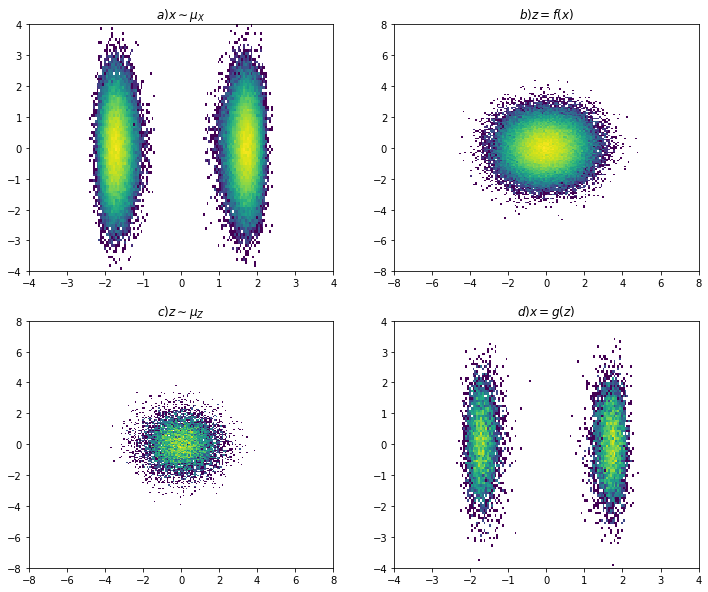

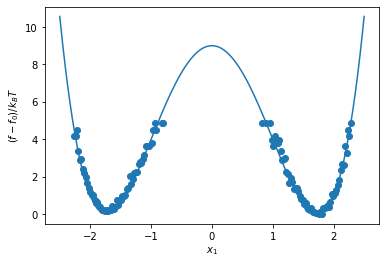

0

In [23]:
# Visualize 
fig, axes = plt.subplots(2, 2, figsize = (12,10))

#
plt.subplot(221)
ax=plt.gca()
ax.hist2d(x_brute[:,0],x_brute[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$a) x \sim \mu_X$')

#
zb=model_SNF.backward_flow(torch.from_numpy(training_data))[0].detach().numpy()
plt.subplot(222)
ax=plt.gca()
ax.hist2d(zb[:,0],zb[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$b) z = f(x)$')

#
z, x, _ = model_SNF.sample(10000)
plt.subplot(223)
ax=plt.gca()
ax.hist2d(z[:,0],z[:,1],bins=100,norm=matplotlib.colors.LogNorm())
#plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$c) z \sim \mu_Z$')

#
plt.subplot(224)
ax=plt.gca()
ax.hist2d(x[:,0],x[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$d) x = g(z)$')

plt.show()

plot_energy(x[:,0]) #plot energy